![logos](media/logos.png)

# Practical Demonstration of New User-Requested Nav2 Features #


## Who Am I?

Hi, I'm [Steve Macenski](https://www.linkedin.com/in/steve-macenski-41a985101/). I do a great deal of different "robotics stuff" at [Samsung Research America](https://www.sra.samsung.com/) as the *Open-Source Robotics, Engineering Lead*. I consult with internal Samsung robotics teams on technology and business, work on mobile robot and perception research, and lead the ROS2 mobile robotics ecosystem. I sit on the [ROS2 TSC](https://docs.ros.org/en/foxy/Governance.html) and I am the leader of the Navigation Working Group. 

Before my current role, I was the leader of the robotics team at [Simbe Robotics](https://www.simberobotics.com/) and worked on NASA's Asteroid Redirect Robotic Mission and RESTORE-L (a  servicing mission to Landsat-7).

## Overview

Nav2 is the second generation of the ROS Navigation Stack. It contains a growing set of capabilities, algorithms, and features to build production and research applications. You can find more information about Nav2 at: https://navigation.ros.org.

In the following talk, we're going to discuss some of the more basic new features in Nav2 that can help you build your research or applications. This includes:

- Basic Nav2 operation through Rviz2 using **NavigateToPose**
- Basic Nav2 operation through a Python3 script using **NavigateThroughPoses**
- Use of the Waypoint Follower and Task Executor plugins via **FollowWaypoints**
- Introduction to keepout zones and speed restricted zones

We will then put all of these together to show a basic autonomous robotics demo based on Nav2. We will be doing this in a simulated warehouse where robots are often deployed:

<img src="media/warehouse_mp400.png" alt="drawing" width="800"/>

We will be using the AWS [Small Warehouse World](https://github.com/aws-robotics/aws-robomaker-small-warehouse-world) and Neobotix's [MP-400](https://www.neobotix-robots.com/products/mobile-robots/mobile-robot-mp-400) mobile industrial robot. 

The code for this presentation, instructions, and install instructions to run locally can be found on my GitHub project as well: https://github.com/SteveMacenski/nav2_rosdevday_2021

## Nav2 Overview

- Independent, modular servers
- Configurable navigation logic, dynamically loaded BT nodes, and per-task behavior selection
- A growing set of run-time reconfigurable algorithms and plugins
- Software quality, linting, and testing (86% test coverage)
- Documentation and a rich community with Slack and Working Group (Join us! [Sign up for the working group here](https://calendar.google.com/calendar/u/0/embed?src=agf3kajirket8khktupm9go748@group.calendar.google.com&ctz=America/Los_Angeles))



<img src="https://navigation.ros.org/_images/architectural_diagram.png" alt="drawing" width="800"/>


---

## Part 1) Let's Get Started!

While that's building, lets inspect the `nav2_rosdevday_2021` package a little... You'll find:

    - launch: Launch files for the simulation, nav2, rviz, and robot state publisher. It's a one-stop shop for bringup. Setting `use_sim_time:=False` and `use_simulator:=False` allows you to launch with hardware!
    - maps: Maps and costmap filter masks for navigation
    - params: parameter files for navigation
    - worlds: simulation world files containing the robot and warehouse models
    - scripts: basic autonomy scripts

Once your packages have built and are setup, running the command below should launch Nav2, the simulation, and Rviz2:

`ros2 launch nav2_rosdevday_2021 system_launch.py`

<img src="media/initial_view.png" alt="drawing" width="800"/>


Now in your terminal you're probably seeing a bunch of messages pass by, that's OK. We have now yet set our initial position, so the servers are unable to finish the lifecycle initialization to start safe navigation. This is their way of individually complaining until you tell the system roughly where the robot is starting at.

You can do this through Rviz2 using **`2D Pose Estimation`** at the robot's position in the world for a demonstration or testing. You can also do this programmatically for a real system which we can mock up via (in a new terminal):

``` bash
source /opt/ros/galactic/setup.bash
ros2 topic pub /initialpose geometry_msgs/msg/PoseWithCovarianceStamped "{header: {stamp: {sec: 0}, frame_id: 'map'}, pose: {pose: {position: {x: 3.45, y: 2.15, z: 0.0}, orientation: {z: 1.0, w: 0.0}}}}"
```

<img src="media/pose_set.png" alt="drawing" width="800"/>

You should now see the robot initialized at its position, the costmaps update in Rviz2, and the warnings should stop.

Now, simply use the **`Nav2 Goal`** button to request the robot to go to a specific goal to test it out!

In [1]:
from IPython.display import HTML

HTML("""
    <video alt="test" loop autoplay width=800>
        <source src="./media/first_test.mp4" type="video/mp4">
    </video>
""")

#### **Now you're navigating!** 

Play around, get a feel for it. If you find yourself in a bad state at any time during this tutorial, feel free to close out the application and relaunch with the instructions above.

#### Rviz2 Plugin

In Rviz2, you'll notice Nav2's panel. You can view action **feedback**, **cancel** a current action, **accumulate** waypoints for execution, or control the **lifecycle** of Nav2.

<img src="media/rviz_plugin.png" alt="drawing" width="500"/>


---

## Part 2) Navigate Actions

There are three primary navigation actions the Nav2 stack exposes currently. Let's explore each with basic python3 autonomy scripts. All of this can be done in Rviz2 as well. 

### Navigate To Pose

Lets demonstrate this using Rviz2 and the Nav2 plugin to walk through a basic notional **picking** autonomy task.

The NavigateToPose action is most suitable for point-to-point navigation requests or for other tasks that can be represented in a behavior tree with a boundary condition pose, such as dynamic object following.

NavigateToPose.action:

``` bash
#goal definition
geometry_msgs/PoseStamped pose
string behavior_tree
---
#result definition
std_msgs/Empty result
---
# feedback definition
geometry_msgs/PoseStamped current_pose
builtin_interfaces/Duration navigation_time
builtin_interfaces/Duration estimated_time_remaining
int16 number_of_recoveries
float32 distance_remaining
```

As you can see, the action's primary inputs are the `pose` you'd like the robot to navigate to and the (optional) `behavior_tree` to use. If none is specified, it uses the default behavior tree in the BT Navigator. During the action's execution, you'll get feedback with important information like the robot's pose, how much time has elapsed, the estimated time remaining, the distance remaining, and the number of recoveries executed while navigating to the goal. This information can be used to make good autonomy decisions or track progress.  

#### NavToPose Demo
In this demo, we have a notional **picking** task we'd like to complete. In the script `picking_demo.py`, we make use of the `NavigateToPose` action to have our robot drive from its staging point to a shelf for a human to place an item on the robot. Then we drive to the pallet jack for shipping on the next truck out of the warehouse. 

If you look over `picking_demo.py` you'll see the key lines (abbreviated):

``` python3
navigator = BasicNavigator()
navigator.setInitialPose(initial_pose)
navigator.waitUntilNav2Active()
navigator.goToPose(shelf_item_pose)
while not navigator.isNavComplete():
    # do some stuff
if result == NavigationResult.SUCCEEDED:
    navigator.goToPose(shipping_destination)
```


Terminal A:
``` bash
source install/setup.bash
ros2 launch nav2_rosdevday_2021 system_launch.py # startup nav2 + sim
```

Terminal B:
``` bash
source install/setup.bash
python3 src/nav2_rosdevday_2021/scripts/picking_demo.py
```

In [2]:
from IPython.display import HTML

HTML("""
    <video alt="test" loop autoplay width=800>
        <source src="./media/picking.mp4" type="video/mp4">
    </video>
""")

### Navigate Through Poses

Lets demonstrate this using a python3 script to mock up a basic **security** autonomy task.

The NavigateThroughPoses action is most suitable for pose-constrained navigation requests or for other tasks that can be represented in a behavior tree with a set of poses. This will **not** stop at each waypoint, but drive through them in a continuous fashion as a pose constraint. 

NavigateThroughPoses.action:

``` bash
#goal definition
geometry_msgs/PoseStamped[] poses
string behavior_tree
---
#result definition
std_msgs/Empty result
---
#feedback definition
geometry_msgs/PoseStamped current_pose
builtin_interfaces/Duration navigation_time
builtin_interfaces/Duration estimated_time_remaining
int16 number_of_recoveries
float32 distance_remaining
int16 number_of_poses_remaining
```

As you can see, the action's inputs are nearly identical to NavigateToPose, except now we take in a vector of `poses`. The feedback is similar as well, only containing the new `number_of_poses_remaining` field to track progress through the via-points.

#### NavThroughPoses Demo
In this demo, we have a notional **security** task we'd like to complete. In the script `security_demo.py`, we make use of the `NavigateThroughPoses` action to have our robot drive from its staging point through-out the warehouse on a known route. The `NavigateThroughPoses` action just like `NavigateToPose` can deviate in the presence of obstacles, as you will see with the pallet jack in this demo. Once it finishes the route, it starts over and continues until stopped.

If you look over `security_demo.py` you'll see the key lines (abbreviated):

``` python3
navigator = BasicNavigator()
navigator.setInitialPose(initial_pose)
navigator.waitUntilNav2Active()
while rclpy.ok():
    navigator.goThroughPoses(route_poses)
    while not navigator.isNavComplete():
        # do some stuff
    security_route.reverse()
```


Terminal A:
``` bash
source install/setup.bash
ros2 launch nav2_rosdevday_2021 system_launch.py # startup nav2 + sim
```

Terminal B:
``` bash
source install/setup.bash
python3 src/nav2_rosdevday_2021/scripts/security_demo.py
```

In [3]:
from IPython.display import HTML

HTML("""
    <video alt="test" loop autoplay width=800>
        <source src="./media/security.mp4" type="video/mp4">
    </video>
""")

### Waypoint Following

Lets demonstrate this using a python3 script to mock up a basic **inspection** autonomy task.

The FollowWaypoints action is most suitable for simple autonomy tasks where you wish to stop at each waypoint and execute a behavior (e.x. pausing for 2 seconds, taking a picture, waiting for someone to place a box on it, etc). The Nav2 waypoint follower server contains `TaskExecutor` plugins to execute a task at each waypoint.

FollowWaypoints.action:

```
#goal definition
geometry_msgs/PoseStamped[] poses
---
#result definition
int32[] missed_waypoints
---
#feedback definition
uint32 current_waypoint
```

As you can see, the API is pretty simple. It takes in the set of poses, where the last pose is the final goal. The feedback is simply the current waypoint ID it is executing and returns a vector of missed waypoint IDs at the end should any be unnavigable. 

#### Waypoint Following Demo
In this demo, we have a notional **inspection** task we'd like to complete. In the script `inspection_demo.py`, we make use of the `FollowWaypoints` action to have our robot drive from its staging point to a set of inspection points. The Nav2 waypoint follower `TaskExecutor` plugin will be taking images and RFID scans of the shelves that can be analyzed for inventory management.

If you look over `inspection_demo.py` you'll see the key lines (abbreviated):

``` python3
navigator = BasicNavigator()
navigator.setInitialPose(initial_pose)
navigator.waitUntilNav2Active()
navigator.followWaypoints(inspection_points)
while not navigator.isNavComplete():
    # do some stuff
if result == NavigationResult.SUCCEEDED:
    navigator.goToPose(initial_pose)
```

Terminal A:
``` bash
source install/setup.bash
ros2 launch nav2_rosdevday_2021 system_launch.py # startup nav2 + sim
```

Terminal B:
``` bash
source install/setup.bash
python3 src/nav2_rosdevday_2021/scripts/inspection_demo.py
```

In [4]:
from IPython.display import HTML

HTML("""
    <video alt="test" loop autoplay width=800>
        <source src="./media/inspection.mp4" type="video/mp4">
    </video>
""")

---

## BONUS (Costmap Filters for a full application)

In that last demonstrations, the robot drove under the shelving units because the robot was small enough to fit. It also traveled through outlined safety tape marking a robot-free area. Obviously in a real use-case, that would either be unsafe or a bad idea. Lets apply the new **Keepout Zones** costmap filter to this problem. We could also use the **Speed Restricted Zones** filter, but doesn't flow nicely from the last demonstration ;-).

#### Keepout Mask
The keepout mask is a file, similar to a map, that contains the mask to apply as the keepout zone. This does not have to be binary no-go zones, it can also just embed areas of higher cost that are still possible to traverse if there are no better alternatives. We've pre-generated one for this demo that makes binary no-go zones in the safety tape and under the shelves.

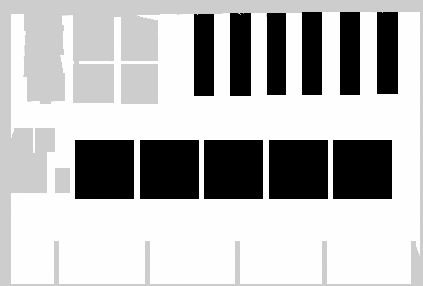

In [1]:
from PIL import Image
Image.open('demo_ws/src/nav2_rosdevday_2021/maps/keepout_rotated2.pgm').transpose(2)

While we won't use it in this demonstration, you can invert this logic and rather than having **keepout** zones, you have **preferred lanes** instead. Below, you'll see a example where we set the main lane of the warehouse as the preferred lanes of travel, but the robot is able to navigate off of them for the final approach to the goal when necessary.


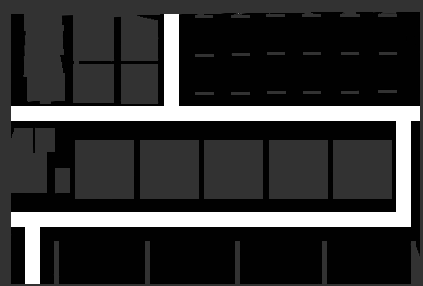

In [48]:
from PIL import Image
Image.open('demo_ws/src/nav2_rosdevday_2021/maps/lanes_rotated.pgm').transpose(2)

#### Configuration 

To use the Keepout Costmap Filter, we have to add it to our `nav2_costmap_2d` configuration and launch a costmap filter and a map server to process the costmap filter mask files into something the costmap filter can handle. These changes are inline in the `global_costmap` and `map_server` areas of `basic_params.yaml`, just uncomment them.

Note: If you are doing this outside of The Construct's platform, make sure to change the `yaml_filepath` in the filter mask server to your actual path to the keepout yaml file.

``` yaml
filters: ["keepout_filter"]
...
keepout_filter:
  plugin: "nav2_costmap_2d::KeepoutFilter"
  enabled: True
  filter_info_topic: "/costmap_filter_info"
...
map_filter_info_server:
  ros__parameters:
    use_sim_time: true
    type: 0
    filter_info_topic: "/costmap_filter_info"
    mask_topic: "/keepout_filter_mask"
    base: 0.0
    multiplier: 1.0

filter_mask_server:
  ros__parameters:
    use_sim_time: true
    frame_id: "map"
    topic_name: "/keepout_filter_mask"
    yaml_filename: "/your/path/to/keepout2.yaml"
```


#### Launch Changes

Finally, we need to add the costmap filter server to our launch file, `system_launch.py`. These lines are already in the file for you, just uncomment them. 

``` python3
    start_lifecycle_manager_cmd = Node(
            package='nav2_lifecycle_manager',
            executable='lifecycle_manager',
            name='lifecycle_manager_costmap_filters',
            output='screen',
            emulate_tty=True,
            parameters=[{'use_sim_time': use_sim_time},
                        {'autostart': True},
                        {'node_names': ['filter_mask_server', 'costmap_filter_info_server']}])

    start_map_server_cmd = Node(
            package='nav2_map_server',
            executable='map_server',
            name='filter_mask_server',
            output='screen',
            emulate_tty=True,
            parameters=[params_file])

    start_costmap_filter_info_server_cmd = Node(
            package='nav2_map_server',
            executable='costmap_filter_info_server',
            name='costmap_filter_info_server',
            output='screen',
            emulate_tty=True,
            parameters=[params_file])
    ...
    ...
    ld.add_action(start_lifecycle_manager_cmd)
    ld.add_action(start_map_server_cmd)
    ld.add_action(start_costmap_filter_info_server_cmd)
```


### Part Putting It All Together

Now you should see the robot no longer go below shelves or try to enter safety zones!

Terminal A:
    
``` bash
source /opt/ros/galactic/setup.bash
colcon build
source install/setup.bash
ros2 launch nav2_rosdevday_2021 system_launch.py
```

Terminal B:
```
source install/setup.bash
python3 inspection_demo.py or picking_demo.py
```


In [5]:
from IPython.display import HTML

HTML("""
    <video alt="test" loop autoplay width=800>
        <source src="./media/inspection_w_keepout.mp4" type="video/mp4">
    </video>
""")

---

# Conclusion

Nav2 is a powerful tool that continues to get more powerful. We are able to navigate to poses, follow tracked dynamic obstacles, respect intermediary pose constraints, and execute tasks while following waypoints. Further, keepout and speed restricted zones make it possible to define regions of the map to have specialized behavior to influence freespace planning. These features, and many more, area available exclusively in ROS2 and Nav2.

If you'd like to get started with Nav2, see https://navigation.ros.org. If you'd like to get involved in the Nav2 project, consider joining our [working group meetings](https://calendar.google.com/calendar/u/0/embed?src=agf3kajirket8khktupm9go748@group.calendar.google.com) or contacting the team. We're open to contributions from any skill level or interest! We have on-going projects in testing, documentation, control, planning, perception, localization, and more!